In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import AutoTokenizer, VisualBertModel,  VisualBertConfig  # PyTorch VisualBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from collections import Counter, defaultdict
import json
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
from transformers import get_linear_schedule_with_warmup

## Project Overview: Visual Question Answering (VQA) with VisualBERT

This project implements and evaluates a Visual Question Answering (VQA) system using the VisualBERT architecture. VQA is a challenging task that requires a model to understand both an image and a natural language question about that image, and then provide an accurate answer. The primary goal of this project was to explore the effectiveness of VisualBERT in this multimodal task, specifically by comparing a model with a frozen VisualBERT encoder against one where the entire VisualBERT model is fine-tuned.

## Dataset and Preprocessing

**Dataset**: The project utilizes a subset of the VQA 2.0 dataset (specifically the validation split of MS COCO).

- **Annotations**: `v2_mscoco_val2014_annotations.json`
- **Questions**: `v2_OpenEnded_mscoco_val2014_questions.json`
- **Images**: `val2014` directory

**Preprocessing Steps**:

1.  **Answer Aggregation**: For each question-image pair, multiple human-provided answers are available. The most common answer among these is selected as the ground truth for training to simplify the classification task.
2.  **Answer Encoding**: All unique answers are collected, and a `LabelEncoder` is used to convert these categorical answer strings into numerical integer IDs. This creates a vocabulary of `14,088` unique answers.
3.  **Feature Extraction**:
    *   **Visual Features**: A pre-trained `ResNet50` model (without its final classification layer) is used to extract 2048-dimensional global visual features from each image. Images are resized to (224, 224) and normalized using ImageNet's mean and standard deviation.
    *   **Textual Features**: A `bert-base-uncased` tokenizer is employed to convert natural language questions into token IDs, attention masks, and token type IDs, with a maximum sequence length of `128`.
4.  **Caching**: To speed up training, all extracted image and text features, along with encoded answers, are pre-computed and cached to disk (`vqa_val_features_pytorch.pkl`).
5.  **Data Splitting**: The processed data is split into training (`150,467` samples), validation (`21,128` samples), and test (`42,759` samples) sets, ensuring that all questions related to a single image are kept within the same split to avoid data leakage.

## Model Architectures and Training Strategy

Two distinct models were trained and evaluated:

### Model 1: Frozen VisualBERT + Small Classification Head

-   **VisualBERT**: A `VisualBertModel` (initialized with `bert-base-uncased` weights and a `visual_embedding_dim` of 2048) is used. **All parameters of the VisualBERT model are frozen**, meaning they are not updated during training.
-   **Classification Head**: A small `nn.Sequential` classifier consisting of a `Linear` layer, `ReLU` activation, `Dropout`, and a final `Linear` layer (mapping from 768-dimensional VisualBERT output to `num_answers` classes) is trained.
-   **Training**: Only the parameters of the classification head are optimized using `Adam` with a learning rate of `1e-4` for `10` epochs. The VisualBERT model remains in `eval()` mode throughout training.

### Model 2: Fine-tuned VisualBERT + Classification Head

-   **VisualBERT**: The same `VisualBertModel` architecture is used, but **all its parameters are made trainable**.
-   **Classification Head**: A slightly larger `nn.Sequential` classifier (with additional layers) is used, mapping from 768-dimensional VisualBERT output to `num_answers` classes.
-   **Training**: All parameters of both the VisualBERT model and the classification head are optimized using `Adam` with a smaller learning rate of `2e-5` for `10` epochs. A `Linear LR scheduler with Warmup` is applied to stabilize training. The entire model is set to `train()` mode.

## Results and Discussion

**Evaluation Metrics**: Both models were evaluated on the test set using Categorical Accuracy and Macro-averaged Precision, Recall, and F1-score from a classification report.

**Observed Performance (After 10 Epochs)**:

**Model 1 (Frozen VisualBERT + Head)**:
-   Test Loss: `3.9324`
-   Test Categorical Accuracy: `0.2810`
-   Macro Avg Precision: `0.0012`
-   Macro Avg Recall: `0.0015`
-   Macro Avg F1-score: `0.0010`

**Model 2 (Fine-tuned VisualBERT + Head)**:
-   Test Loss: `3.7551`
-   Test Categorical Accuracy: `0.2702`
-   Macro Avg Precision: `0.0004`
-   Macro Avg Recall: `0.0010`
-   Macro Avg F1-score: `0.0005`

**Insights**:

-   Surprisingly, Model 1 (Frozen VisualBERT) achieved slightly better overall accuracy and macro-averaged metrics compared to Model 2 (Fine-tuned VisualBERT). This could be due to several factors:
    -   **Limited Training Epochs**: Both models were trained for only `10` epochs. Fine-tuning a large model like VisualBERT typically requires significantly more epochs and careful hyperparameter tuning to converge and surpass the performance of a frozen baseline. The fine-tuned model might still be in an early stage of learning where it's adjusting its vast number of parameters, leading to temporary instability or slower convergence.
    -   **Catastrophic Forgetting/Stability**: Without sufficient training data or specialized fine-tuning strategies (like discriminative learning rates for different layers), fine-tuning a large pre-trained model can sometimes lead to an initial drop in performance as the model 'forgets' some of its pre-trained knowledge before adapting to the new task.
    -   **Classification Head Complexity**: While Model 2's head was slightly larger, the benefit of this might not be realized without more extensive training.
    -   **Class Imbalance**: As indicated by the low Macro Avg Precision, Recall, and F1-score for both models, the VQA dataset often suffers from severe class imbalance, where common answers dominate. This makes it hard for models to predict less frequent answers, impacting overall performance, especially when considering macro averages.

**Conclusion**: The project demonstrates the setup for VQA using VisualBERT. To achieve state-of-the-art performance, further experimentation with more training epochs, advanced fine-tuning techniques, and strategies to handle class imbalance would be necessary. The current results serve as a foundational benchmark, highlighting the initial learning capabilities of both frozen and fine-tuned VisualBERT approaches.

## How to Upload Your Project to Git (e.g., GitHub, GitLab)

Follow these steps to initialize a Git repository for your project and push it to a remote server. This assumes you already have Git installed on your system.

### Step 1: Initialize a Git Repository

Navigate to your project directory in the terminal (or Colab's terminal if you're using local files).

```bash
cd /path/to/your/project
git init
```

This command creates a new hidden `.git` directory in your project folder, which is where Git stores all its tracking information.

### Step 2: Add Files to the Staging Area

Tell Git which files you want to include in your next commit.

```bash
git add .
```

This command adds all current files and directories in your project to the staging area. If you only want to add specific files, replace `.` with the file or directory names (e.g., `git add my_script.py data/`).

### Step 3: Commit Your Changes

Save the staged changes to your repository with a descriptive message.

```bash
git commit -m "Initial project setup: VQA with VisualBERT, data loading and preprocessing."
```

Replace the message with one that accurately describes the changes you're committing.

### Step 4: Create a Repository on a Remote Hosting Service (e.g., GitHub)

Go to your preferred Git hosting service (GitHub, GitLab, Bitbucket, etc.) and create a new empty repository. Do NOT initialize it with a README, license, or `.gitignore` yet, as you'll be pushing an existing project.

Once created, the service will usually provide you with commands to link your local repository. It will look something like this:

### Step 5: Link Your Local Repository to the Remote Repository

```bash
git remote add origin <YOUR_REMOTE_REPOSITORY_URL>
```

Replace `<YOUR_REMOTE_REPOSITORY_URL>` with the URL provided by your hosting service (e.g., `https://github.com/your-username/your-repo-name.git`).

### Step 6: Push Your Local Changes to the Remote Repository

```bash
git push -u origin main
```

-   `git push`: Sends your committed changes to the remote repository.
-   `-u origin main`: Sets the upstream for your local `main` branch to the `origin` remote. This means that future `git push` and `git pull` commands will automatically know where to go without specifying `origin main`.
    *   (Note: The default branch name is often `main` now, but could be `master` in older setups. Adjust if necessary.)

Your project should now be live on your Git hosting service!

### Step 7: Subsequent Changes

For any future changes you make:

1.  **Stage changes**: `git add .` (or specific files)
2.  **Commit changes**: `git commit -m "Your descriptive message here"`
3.  **Push changes**: `git push`

In [ ]:
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
VQA_ANNOTATIONS_PATH = "/home/BTECH_7TH_SEM/Desktop/MML/VQA/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json"
VQA_QUESTIONS_PATH = "/home/BTECH_7TH_SEM/Desktop/MML/VQA/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json"
IMAGE_DIR = "/home/BTECH_7TH_SEM/Desktop/MML/VQA/val2014"

In [ ]:
# Model and training parameters
MAX_SEQ_LEN = 128 # Kept from original, adjust if needed
BATCH_SIZE = 16
NUM_EPOCHS_MODEL1 = 10
NUM_EPOCHS_MODEL2 = 10
VAL_SPLIT_RATIO = 0.1
TEST_SPLIT_RATIO = 0.2

# Feature caching paths
CACHED_FEATURES_PATH = 'vqa_val_features_pytorch.pkl' # Renamed to avoid clash
CACHED_LABEL_ENCODER_PATH = 'vqa_answer_label_encoder_pytorch.pkl' # Renamed

# Model save paths (will save state_dicts for components)
MODEL_COMPONENTS_PATH_FROZEN = 'visualbert_frozen_head_vqa_components_pytorch.pth'
MODEL_COMPONENTS_PATH_FINE_TUNED = 'visualbert_fine_tuned_vqa_components_pytorch.pth'

In [ ]:
# --- 1. Load VQA Dataset ---
print("Loading VQA dataset...")
with open(VQA_QUESTIONS_PATH, 'r') as f:
    vqa_questions = json.load(f)['questions']
with open(VQA_ANNOTATIONS_PATH, 'r') as f:
    vqa_annotations = json.load(f)['annotations']

# Create a mapping from question_id to annotation
q_id_to_anno = {anno['question_id']: anno for anno in vqa_annotations}

# Combine questions and annotations
vqa_data = []
all_answers = []

for q in vqa_questions:
    q_id = q['question_id']
    if q_id in q_id_to_anno:
        anno = q_id_to_anno[q_id]

        # Get the most frequent answer for simplification
        answers = [a['answer'] for a in anno['answers']]
        if not answers:
            continue
        # Count answer occurrences and pick the most common one
        most_common_answer = Counter(answers).most_common(1)[0][0]

        vqa_data.append({
            'image_id': q['image_id'],
            'question': q['question'],
            'answer': most_common_answer, # Using the most common answer
            'raw_answers': answers, # Keep raw answers for evaluation if needed
            'question_id': q_id # Keep question ID to link to annotations
        })
        all_answers.append(most_common_answer)

print(f"Loaded {len(vqa_data)} VQA samples.")

Loading VQA dataset...
Loaded 214354 VQA samples.


v2_OpenEnded_mscoco_val2014_questions.json:: list of dictionaries, where each dictionary represents a question.
v2_mscoco_val2014_annotations.json: This file contains a list of dictionaries, each providing annotations for a specific question-image pair
vqa_data:For each question, it identifies the most frequent human answer as the "ground truth" answer for training.
all_answers:list of all the 'most common' answer strings collected from vqa_data

In [ ]:
q_id_to_anno

{262148000: {'question_type': 'none of the above',
  'multiple_choice_answer': 'down',
  'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
   {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
   {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
   {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 8},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 9},
   {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 10}],
  'image_id': 262148,
  'answer_type': 'other',
  'question_id': 262148000},
 262148001: {'question_type': 'what are the',
  'multiple_choice_answer': 'watching',
  'answers': [{'answer': 'spectating',
    'answer_confi

In [ ]:
vqa_data

[{'image_id': 262148,
  'question': 'Where is he looking?',
  'answer': 'down',
  'raw_answers': ['down',
   'down',
   'at table',
   'skateboard',
   'down',
   'table',
   'down',
   'down',
   'down',
   'down'],
  'question_id': 262148000},
 {'image_id': 262148,
  'question': 'What are the people in the background doing?',
  'answer': 'watching',
  'raw_answers': ['spectating',
   'watching',
   'watching',
   'watching',
   'watching',
   'watching',
   'watching',
   'watching',
   'watching',
   'watching'],
  'question_id': 262148001},
 {'image_id': 262148,
  'question': 'What is he on top of?',
  'answer': 'picnic table',
  'raw_answers': ['table',
   'table',
   'table',
   'picnic table',
   'picnic table',
   'picnic table',
   'picnic table',
   'picnic table',
   'skateboard',
   'picnic table'],
  'question_id': 262148002},
 {'image_id': 393225,
  'question': 'What website copyrighted the picture?',
  'answer': 'foodiebakercom',
  'raw_answers': ['foodiebakercom',
   'f

In [ ]:
unique_image_ids = set()
for item in vqa_data:
    unique_image_ids.add(item['image_id'])
num_unique_images = len(unique_image_ids)
print(f"Number of unique images: {num_unique_images}")

# 2. Questions per Image
image_to_questions = defaultdict(list)
for item in vqa_data:
    image_to_questions[item['image_id']].append(item['question'])

num_questions_per_image = [len(questions) for questions in image_to_questions.values()]
print(f"\nQuestions per Image:")
print(f"  Min questions for an image: {np.min(num_questions_per_image)}")
print(f"  Max questions for an image: {np.max(num_questions_per_image)}")

Number of unique images: 40504

Questions per Image:
  Min questions for an image: 3
  Max questions for an image: 132


In [ ]:
num_answers_per_question = []
for item in vqa_data:
    num_answers_per_question.append(len(item['raw_answers']))

if len(set(num_answers_per_question)) == 1:
    print(f"\nAnswers per Question (human annotations):")
    print(f"  Each question-image pair has {num_answers_per_question[0]} human answers.")
else:
    print(f"\nAnswers per Question (human annotations):")
    print(f"  Min human answers for a question: {np.min(num_answers_per_question)}")
    print(f"  Max human answers for a question: {np.max(num_answers_per_question)}")

print(f"\nTotal number of (image, question, answer) triplets processed: {len(vqa_data)}")



Answers per Question (human annotations):
  Each question-image pair has 10 human answers.

Total number of (image, question, answer) triplets processed: 214354


In [ ]:
# Top K most common answers
answer_counts = Counter(all_answers)
print("\nTop 10 most common answers:")
for answer, count in answer_counts.most_common(10):
    print(f"  '{answer}': {count} occurrences")


Top 10 most common answers:
  'no': 41098 occurrences
  'yes': 39750 occurrences
  '1': 5973 occurrences
  '2': 5864 occurrences
  'white': 4365 occurrences
  '3': 2973 occurrences
  'blue': 2613 occurrences
  'black': 2560 occurrences
  'red': 2556 occurrences
  '0': 2361 occurrences


In [ ]:
# Top K most common answers
answer_counts = Counter(all_answers)
print("\nTop 10 most common answers:")
for answer, count in answer_counts.most_common()[:-11:-1]:
    print(f"  '{answer}': {count} occurrences")


Top 10 most common answers:
  'go left': 1 occurrences
  'clutter': 1 occurrences
  'too cloudy': 1 occurrences
  'can't read': 1 occurrences
  'baby monkey': 1 occurrences
  '3.65': 1 occurrences
  '8231': 1 occurrences
  'to fly two planes': 1 occurrences
  'back wing': 1 occurrences
  'direct rail services': 1 occurrences


In [ ]:
question_type_counts = Counter()
total_questions_with_type = 0

for item in vqa_data:
    q_id = item['question_id']
    if q_id in q_id_to_anno:
        annotation = q_id_to_anno[q_id]
        answer_type = annotation.get('answer_type')
        if answer_type:
            question_type_counts[answer_type] += 1
            total_questions_with_type += 1

print("Distribution of Question Types:")
for q_type, count in question_type_counts.most_common():
    percentage = (count / total_questions_with_type) * 100
    print(f"  '{q_type}': {count} ({percentage:.2f}%)")

if total_questions_with_type < len(vqa_data):
    print(f"\nNote: {len(vqa_data) - total_questions_with_type} questions in vqa_data did not have an 'answer_type' field in their annotation or were filtered out.")

Distribution of Question Types:
  'other': 105679 (49.30%)
  'yes/no': 80541 (37.57%)
  'number': 28134 (13.13%)


In [ ]:

# converting the unique categorical answers (e.g., "yes", "no", "2") into numerical integer IDs.
answer_label_encoder = LabelEncoder()
answer_label_encoder.fit(all_answers)
num_answers = len(answer_label_encoder.classes_)
print(f"\nTotal unique answers (vocabulary size for model output): {num_answers}")

print("\nEncoding answers into numerical labels")
all_answers_for_encoding = [item['answer'] for item in vqa_data]
encoded_answer_ids = answer_label_encoder.transform(all_answers_for_encoding)

for i, item in enumerate(vqa_data):
    item['answer_id'] = encoded_answer_ids[i] #An integer ID is added to each dictionary in vqa_data representing the encoded answer.

print("Finished encoding answers.")


Total unique answers (vocabulary size for model output): 14088

Encoding answers into numerical labels
Finished encoding answers.


answer_label_encoder: It learns a mapping from unique answer strings to unique integer IDs (e.g., "a dog" -> 0, "yes" -> 1, "no" -> 2, etc.)
item['answer_id']: An integer ID is added to each dictionary in vqa_data representing the encoded answer.

In [ ]:
# --- 2. Feature Extractors (ResNet50 for Vision, BERT for Text) (Unchanged) ---

# ResNet50 for visual features
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1]) # Remove the FC layer
resnet_model.eval() # Set to evaluation mode, disables dropout, batch normalization updates
resnet_model.to(device)

# ImageNet normalization values
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Converts to [0, 1] range
    normalize # Normalizes the pixel values using ImageNet's mean and standard deviation.
    # This is crucial because ResNet50 was trained on ImageNet with this normalization.
])

def get_image_features(image_id):
    image_filename = f"COCO_val2014_{str(image_id).zfill(12)}.jpg"
    image_path = os.path.join(IMAGE_DIR, image_filename)
    if not os.path.exists(image_path):
        return None
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = image_transform(img).unsqueeze(0).to(device) # Add batch dimension and move to device

        with torch.no_grad(): # No need to calculate gradients for feature extraction
            #preprocessed tensor (shape (1, 3, 224, 224)) is passed through the resnet_model
            features = resnet_model(img_tensor)

        return features.squeeze().cpu().numpy() # (2048,) and move back to CPU as numpy
    except Exception as e:
        print(f"Error processing image {image_id} at {image_path}: {e}")
        return None

# BERT for textual features
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/home/BTECH_7TH_SEM/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/BTECH_7TH_SEM/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/BTECH_7TH_SEM/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 40.1MB/s]


This tokenizer is responsible for breaking down questions into subword tokens, converting them to numerical IDs, adding special tokens ([CLS], [SEP]), and creating attention masks and token type IDs required by BERT-like models. return_tensors='pt' ensures PyTorch tensors are returned.

input_ids: A numpy.ndarray of shape (MAX_SEQ_LEN,) (e.g., (128,)). This contains integer IDs representing the tokens in the question.
attention_mask: A numpy.ndarray of shape (MAX_SEQ_LEN,). Contains 1 for actual tokens and 0 for padding tokens.
token_type_ids: A numpy.ndarray of shape (MAX_SEQ_LEN,). Typically all 0s for single-sentence inputs.

In [ ]:
processed_data = []
print("\nPre-computing image and text features (and will save to cache)...")
for i, item in enumerate(vqa_data):
    if (i + 1) % 5000 == 0:
        print(f"Processing item {i+1}/{len(vqa_data)}")

    img_features = get_image_features(item['image_id']) # extract ResNet50 features
    if img_features is None:
        continue
# bert_tokenizer processes the question into input_ids, attention_mask, and token_type_ids
    encoded_text = bert_tokenizer(
        item['question'],
        padding='max_length',
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors='pt' # Return PyTorch tensors
    )

    processed_data.append({
        'image_features': img_features, # Stored as numpy, converted to tensor in Dataset
        'input_ids': encoded_text['input_ids'].squeeze().numpy(),
        'attention_mask': encoded_text['attention_mask'].squeeze().numpy(),
        'token_type_ids': encoded_text['token_type_ids'].squeeze().numpy(),
        'answer_id': item['answer_id'], # Stored as int, converted to tensor in Dataset
        'original_image_id': item['image_id'],
        'original_question': item['question']
    })

print(f"Finished pre-computing features for {len(processed_data)} samples.")


Pre-computing image and text features (and will save to cache)...
Processing item 5000/214354
Processing item 10000/214354
Processing item 15000/214354
Processing item 20000/214354
Processing item 25000/214354
Processing item 30000/214354
Processing item 35000/214354
Processing item 40000/214354
Processing item 45000/214354
Processing item 50000/214354
Processing item 55000/214354
Processing item 60000/214354
Processing item 65000/214354
Processing item 70000/214354
Processing item 75000/214354
Processing item 80000/214354
Processing item 85000/214354
Processing item 90000/214354
Processing item 95000/214354
Processing item 100000/214354
Processing item 105000/214354
Processing item 110000/214354
Processing item 115000/214354
Processing item 120000/214354
Processing item 125000/214354
Processing item 130000/214354
Processing item 135000/214354
Processing item 140000/214354
Processing item 145000/214354
Processing item 150000/214354
Processing item 155000/214354
Processing item 160000/

Feature Extraction (Images via ResNet50, Questions via BERT Tokenizer)
Images: Raw .jpg -> PIL Image -> Transformed PyTorch Tensor -> ResNet50 Features (NumPy Array)
Text: Raw string -> BERT Tokenizer (PyTorch Tensors) -> NumPy Arrays

Independent Feature Extraction:
Visual Branch: Your get_image_features function uses a pre-trained ResNet50 model to extract a 2048-dimensional global feature vector for each image. This is a high-level summary of the image content.
Textual Branch: Your bert_tokenizer converts the question text into input_ids, attention_mask, and token_type_ids. These represent the individual words/subword tokens of the question.

In [ ]:
# Save processed_data and the LabelEncoder
with open(CACHED_FEATURES_PATH, 'wb') as f:
    pickle.dump(processed_data, f)
print(f"Processed data (features) saved to {CACHED_FEATURES_PATH}")

with open(CACHED_LABEL_ENCODER_PATH, 'wb') as f:
    pickle.dump(answer_label_encoder, f)
print(f"Answer Label Encoder saved to {CACHED_LABEL_ENCODER_PATH}")

print("\nFeature extraction and saving complete.")


Processed data (features) saved to vqa_val_features_pytorch.pkl
Answer Label Encoder saved to vqa_answer_label_encoder_pytorch.pkl

Feature extraction and saving complete.


In [ ]:
# --- 4. PyTorch Dataset Class ---
class VQADataset(Dataset):
    def __init__(self, data_list, num_answers):
        self.data_list = data_list
        self.num_answers = num_answers

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        # Convert numpy arrays to torch tensors
        image_features = torch.tensor(item['image_features'], dtype=torch.float32)
        input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(item['token_type_ids'], dtype=torch.long)

        # answer_id should be long tensor for CrossEntropyLoss
        answer_id = torch.tensor(item['answer_id'], dtype=torch.long)

        return {
            'image_features': image_features,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }, answer_id


#### Loading features for model training

In [ ]:
with open(CACHED_FEATURES_PATH, 'rb') as f:
    processed_data = pickle.load(f)
print(f"Loaded {len(processed_data)} cached samples.")

with open(CACHED_LABEL_ENCODER_PATH, 'rb') as f:
    answer_label_encoder = pickle.load(f)
    num_answers = len(answer_label_encoder.classes_) # Ensure num_answers is correctly set here
print("Loaded answer label encoder.")
print(f"Total unique answers (vocabulary size): {num_answers}")


Loaded 214354 cached samples.
Loaded answer label encoder.
Total unique answers (vocabulary size): 14088


In [ ]:
random.seed(42)
np.random.seed(42)

In [ ]:
# --- Data Splitting (Image-based) ---
print("\nSplitting data into train, validation, and test sets (image-based)...")

all_processed_image_ids = np.array([d['original_image_id'] for d in processed_data])
unique_processed_image_ids = np.unique(all_processed_image_ids)

train_img_ids, val_test_img_ids = train_test_split(
    unique_processed_image_ids, test_size=(VAL_SPLIT_RATIO + TEST_SPLIT_RATIO), random_state=42
)
val_img_ids, test_img_ids = train_test_split(
    val_test_img_ids, test_size=(TEST_SPLIT_RATIO / (VAL_SPLIT_RATIO + TEST_SPLIT_RATIO)), random_state=42
)

train_data_filtered = [d for d in processed_data if d['original_image_id'] in train_img_ids]
val_data_filtered = [d for d in processed_data if d['original_image_id'] in val_img_ids]
test_data_filtered = [d for d in processed_data if d['original_image_id'] in test_img_ids]

print(f"  Train samples: {len(train_data_filtered)}")
print(f"  Validation samples: {len(val_data_filtered)}")
print(f"  Test samples: {len(test_data_filtered)}")


# Create PyTorch Datasets and DataLoaders
train_dataset = VQADataset(train_data_filtered, num_answers)
val_dataset = VQADataset(val_data_filtered, num_answers)
test_dataset = VQADataset(test_data_filtered, num_answers)

# Removed num_workers=4 for serial execution
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Splitting data into train, validation, and test sets (image-based)...
  Train samples: 150467
  Validation samples: 21128
  Test samples: 42759


In [ ]:
# --- Model 1: Frozen VisualBERT + Small Classification Head ---
print("\n--- Building and Training Model 1: Frozen VisualBERT + Small Head ---")

# Define common VisualBERT config to ensure internal visual_projection is correctly sized
visualbert_config = VisualBertConfig.from_pretrained('bert-base-uncased')
visualbert_config.visual_embedding_dim = 2048 # ResNet50 output dim

# Model 1 Components
visualbert_m1 = VisualBertModel.from_pretrained('bert-base-uncased', config=visualbert_config).to(device)

# --- CRITICAL: Freeze ALL VisualBERT parameters for Model 1 ---
for name, param in visualbert_m1.named_parameters():
    param.requires_grad = False

# Only the classification head needs to be trained
classifier_m1 = nn.Sequential(
    nn.Linear(768, 512), # VisualBERT pooler_output is 768
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_answers)
).to(device)

# Optimizer for Model 1 should ONLY include parameters from classifier_m1
optimizer_m1 = optim.Adam(
    classifier_m1.parameters(), # Only optimize the classifier
    lr=1e-4 # Higher LR for just the head
)
criterion = nn.CrossEntropyLoss() # Expects raw logits and class indices

# Verify trainable parameters
trainable_params_m1 = sum(p.numel() for p in classifier_m1.parameters() if p.requires_grad)
print(f"\nModel 1 trainable parameters: {trainable_params_m1}.")

history_m1 = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(NUM_EPOCHS_MODEL1):
    # --- Train Epoch Model 1 ---
    visualbert_m1.eval() # Keep VisualBERT in eval mode since frozen
    classifier_m1.train()
    total_loss_train = 0
    correct_predictions_train = 0
    total_samples_train = 0

    # Add tqdm to the training dataloader
    train_loop = tqdm(train_dataloader, desc=f"Model 1 Train Epoch {epoch+1}/{NUM_EPOCHS_MODEL1}")
    for batch_idx, (inputs, labels) in enumerate(train_loop):
        image_features = inputs['image_features'].to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        labels = labels.to(device)

        optimizer_m1.zero_grad()

        # Forward pass for Model 1
        visual_embeds_for_visualbert = image_features.unsqueeze(1) # (batch_size, 1, 2048) VisualBERT (and Transformer models in general) expects input embeddings to be in the format
        visual_attention_mask = torch.ones_like(visual_embeds_for_visualbert[:, :, 0], dtype=torch.long)

        with torch.no_grad(): # Ensure no gradients for frozen VisualBERT
            visualbert_output = visualbert_m1(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                visual_embeds=visual_embeds_for_visualbert, # Pass 2048-dim features here
                visual_attention_mask=visual_attention_mask
            )
        combined_representation = visualbert_output.pooler_output # This will be 768-dim
        outputs = classifier_m1(combined_representation)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_m1.step()

        total_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

        # Update tqdm progress bar with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), acc=(correct_predictions_train / total_samples_train))

    train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_predictions_train / total_samples_train

    # --- Validate Epoch Model 1 ---
    visualbert_m1.eval()
    classifier_m1.eval()
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    # Add tqdm to the validation dataloader
    val_loop = tqdm(val_dataloader, desc=f"Model 1 Val Epoch {epoch+1}/{NUM_EPOCHS_MODEL1}")
    with torch.no_grad():
        for inputs, labels in val_loop:
            image_features = inputs['image_features'].to(device)
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            token_type_ids = inputs['token_type_ids'].to(device)
            labels = labels.to(device)

            # Forward pass for Model 1
            visual_embeds_for_visualbert = image_features.unsqueeze(1)
            visual_attention_mask = torch.ones_like(visual_embeds_for_visualbert[:, :, 0], dtype=torch.long)

            visualbert_output = visualbert_m1(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                visual_embeds=visual_embeds_for_visualbert,
                visual_attention_mask=visual_attention_mask
            )
            combined_representation = visualbert_output.pooler_output
            outputs = classifier_m1(combined_representation)

            loss = criterion(outputs, labels)
            total_loss_val += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

            # Update tqdm progress bar for validation
            val_loop.set_postfix(loss=loss.item(), acc=(correct_predictions_val / total_samples_val))


    val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_predictions_val / total_samples_val

    history_m1['loss'].append(train_loss)
    history_m1['accuracy'].append(train_acc)
    history_m1['val_loss'].append(val_loss)
    history_m1['val_accuracy'].append(val_acc)

    print(f"Model 1 - Epoch {epoch+1}/{NUM_EPOCHS_MODEL1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save state dicts of all components for Model 1
torch.save({
    'visualbert_state_dict': visualbert_m1.state_dict(),
    'classifier_state_dict': classifier_m1.state_dict(),
    'num_answers': num_answers # Save num_answers to reconstruct correctly
}, MODEL_COMPONENTS_PATH_FROZEN)
print(f"Model 1 components saved to {MODEL_COMPONENTS_PATH_FROZEN}")



--- Building and Training Model 1: Frozen VisualBERT + Small Head ---


You are using a model of type bert to instantiate a model of type visual_bert. This is not supported for all configurations of models and can yield errors.
Some weights of VisualBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.visual_position_embeddings.weight', 'embeddings.visual_projection.bias', 'embeddings.visual_projection.weight', 'embeddings.visual_token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.s


Model 1 trainable parameters: 7620872.


Model 1 Train Epoch 1/10: 100%|█| 9405/9405 [03:04<00:00, 51.04it/s, acc=0.217, 
Model 1 Val Epoch 1/10: 100%|█| 1321/1321 [00:25<00:00, 52.09it/s, acc=0.235, lo


Model 1 - Epoch 1/10 | Train Loss: 4.6889, Train Acc: 0.2169 | Val Loss: 4.3830, Val Acc: 0.2347


Model 1 Train Epoch 2/10: 100%|█| 9405/9405 [03:01<00:00, 51.72it/s, acc=0.239, 
Model 1 Val Epoch 2/10: 100%|█| 1321/1321 [00:24<00:00, 53.61it/s, acc=0.238, lo


Model 1 - Epoch 2/10 | Train Loss: 4.1603, Train Acc: 0.2395 | Val Loss: 4.2998, Val Acc: 0.2383


Model 1 Train Epoch 3/10: 100%|█| 9405/9405 [02:58<00:00, 52.55it/s, acc=0.247, 
Model 1 Val Epoch 3/10: 100%|█| 1321/1321 [00:24<00:00, 53.58it/s, acc=0.248, lo


Model 1 - Epoch 3/10 | Train Loss: 3.9891, Train Acc: 0.2472 | Val Loss: 4.2359, Val Acc: 0.2485


Model 1 Train Epoch 4/10: 100%|█| 9405/9405 [02:59<00:00, 52.51it/s, acc=0.252, 
Model 1 Val Epoch 4/10: 100%|█| 1321/1321 [00:24<00:00, 53.61it/s, acc=0.257, lo


Model 1 - Epoch 4/10 | Train Loss: 3.8510, Train Acc: 0.2523 | Val Loss: 4.1634, Val Acc: 0.2574


Model 1 Train Epoch 5/10: 100%|█| 9405/9405 [02:59<00:00, 52.53it/s, acc=0.257, 
Model 1 Val Epoch 5/10: 100%|█| 1321/1321 [00:24<00:00, 53.60it/s, acc=0.251, lo


Model 1 - Epoch 5/10 | Train Loss: 3.7389, Train Acc: 0.2572 | Val Loss: 4.1293, Val Acc: 0.2508


Model 1 Train Epoch 6/10: 100%|█| 9405/9405 [02:59<00:00, 52.50it/s, acc=0.26, l
Model 1 Val Epoch 6/10: 100%|█| 1321/1321 [00:24<00:00, 53.42it/s, acc=0.259, lo


Model 1 - Epoch 6/10 | Train Loss: 3.6414, Train Acc: 0.2604 | Val Loss: 4.0533, Val Acc: 0.2594


Model 1 Train Epoch 7/10: 100%|█| 9405/9405 [02:58<00:00, 52.61it/s, acc=0.266, 
Model 1 Val Epoch 7/10: 100%|█| 1321/1321 [00:24<00:00, 53.57it/s, acc=0.264, lo


Model 1 - Epoch 7/10 | Train Loss: 3.5594, Train Acc: 0.2657 | Val Loss: 4.0419, Val Acc: 0.2641


Model 1 Train Epoch 8/10: 100%|█| 9405/9405 [02:59<00:00, 52.40it/s, acc=0.269, 
Model 1 Val Epoch 8/10: 100%|█| 1321/1321 [00:24<00:00, 53.65it/s, acc=0.269, lo


Model 1 - Epoch 8/10 | Train Loss: 3.4883, Train Acc: 0.2689 | Val Loss: 4.0457, Val Acc: 0.2691


Model 1 Train Epoch 9/10: 100%|█| 9405/9405 [02:59<00:00, 52.49it/s, acc=0.273, 
Model 1 Val Epoch 9/10: 100%|█| 1321/1321 [00:24<00:00, 53.41it/s, acc=0.271, lo


Model 1 - Epoch 9/10 | Train Loss: 3.4255, Train Acc: 0.2731 | Val Loss: 3.9761, Val Acc: 0.2713


Model 1 Train Epoch 10/10: 100%|█| 9405/9405 [02:58<00:00, 52.55it/s, acc=0.277,
Model 1 Val Epoch 10/10: 100%|█| 1321/1321 [00:24<00:00, 53.64it/s, acc=0.279, l


Model 1 - Epoch 10/10 | Train Loss: 3.3711, Train Acc: 0.2769 | Val Loss: 3.9590, Val Acc: 0.2791
Model 1 components saved to visualbert_frozen_head_vqa_components_pytorch.pth


In [ ]:
criterion = nn.CrossEntropyLoss() # Expects raw logits and class indices
# Define common VisualBERT config to ensure internal visual_projection is correctly sized
visualbert_config = VisualBertConfig.from_pretrained('bert-base-uncased')
visualbert_config.visual_embedding_dim = 2048 # ResNet50 output dim


You are using a model of type bert to instantiate a model of type visual_bert. This is not supported for all configurations of models and can yield errors.


In [ ]:
# --- Model 2: Fine-tuned VisualBERT + Classification Head ---
print("\n--- Building and Training Model 2: Fine-tuned VisualBERT + Head ---")

# Model 2 Components
visualbert_m2 = VisualBertModel.from_pretrained('bert-base-uncased', config=visualbert_config).to(device)
# visualbert_m2.trainable = True (default for PyTorch, all parameters are trainable)

classifier_m2 = nn.Sequential(
    nn.Linear(768, 1024), # VisualBERT pooler_output is 768
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_answers)
).to(device)

# Combine ALL parameters for Model 2's optimizer
optimizer_m2 = optim.Adam(
    list(visualbert_m2.parameters()) +
    list(classifier_m2.parameters()),
    lr=2e-5 # Smaller LR for full fine-tuning
)
criterion = nn.CrossEntropyLoss() # Criterion remains the same

# --- Learning Rate Scheduler for Model 2 ---
total_training_steps_m2 = len(train_dataloader) * NUM_EPOCHS_MODEL2
warmup_steps_m2 = int(total_training_steps_m2 * 0.1) # 10% of total steps for warmup

scheduler_m2 = get_linear_schedule_with_warmup(
    optimizer_m2,
    num_warmup_steps=warmup_steps_m2,
    num_training_steps=total_training_steps_m2
)
print(f"Model 2: Using Linear LR scheduler with {warmup_steps_m2} warmup steps out of {total_training_steps_m2} total steps.")


trainable_params_m2 = sum(p.numel() for p in visualbert_m2.parameters() if p.requires_grad) + sum(p.numel() for p in classifier_m2.parameters() if p.requires_grad)
print(f"\nModel 2 trainable parameters: {trainable_params_m2}.")

history_m2 = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(NUM_EPOCHS_MODEL2):
    # --- Train Epoch Model 2 ---
    visualbert_m2.train()
    classifier_m2.train()
    total_loss_train = 0
    correct_predictions_train = 0
    total_samples_train = 0

    train_loop = tqdm(train_dataloader, desc=f"Model 2 Train Epoch {epoch+1}/{NUM_EPOCHS_MODEL2}")
    for batch_idx, (inputs, labels) in enumerate(train_loop):
        image_features = inputs['image_features'].to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        labels = labels.to(device)

        optimizer_m2.zero_grad()

        # Forward pass for Model 2
        visual_embeds_for_visualbert = image_features.unsqueeze(1)
        visual_attention_mask = torch.ones_like(visual_embeds_for_visualbert[:, :, 0], dtype=torch.long)

        visualbert_output = visualbert_m2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            visual_embeds=visual_embeds_for_visualbert,
            visual_attention_mask=visual_attention_mask
        )
        combined_representation = visualbert_output.pooler_output
        outputs = classifier_m2(combined_representation)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_m2.step()
        scheduler_m2.step() # --- IMPORTANT: Update scheduler after optimizer step ---

        total_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item(), acc=(correct_predictions_train / total_samples_train))

    train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_predictions_train / total_samples_train

    # --- Validate Epoch Model 2 ---
    visualbert_m2.eval()
    classifier_m2.eval()
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    val_loop = tqdm(val_dataloader, desc=f"Model 2 Val Epoch {epoch+1}/{NUM_EPOCHS_MODEL2}")
    with torch.no_grad():
        for inputs, labels in val_loop:
            image_features = inputs['image_features'].to(device)
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            token_type_ids = inputs['token_type_ids'].to(device)
            labels = labels.to(device)

            # Forward pass for Model 2
            visual_embeds_for_visualbert = image_features.unsqueeze(1)
            visual_attention_mask = torch.ones_like(visual_embeds_for_visualbert[:, :, 0], dtype=torch.long)

            visualbert_output = visualbert_m2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                visual_embeds=visual_embeds_for_visualbert,
                visual_attention_mask=visual_attention_mask
            )
            combined_representation = visualbert_output.pooler_output
            outputs = classifier_m2(combined_representation)

            loss = criterion(outputs, labels)
            total_loss_val += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

            val_loop.set_postfix(loss=loss.item(), acc=(correct_predictions_val / total_samples_val))

    val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_predictions_val / total_samples_val

    history_m2['loss'].append(train_loss)
    history_m2['accuracy'].append(train_acc)
    history_m2['val_loss'].append(val_loss)
    history_m2['val_accuracy'].append(val_acc)

    print(f"Model 2 - Epoch {epoch+1}/{NUM_EPOCHS_MODEL2} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save state dicts of all components for Model 2
torch.save({
    'visualbert_state_dict': visualbert_m2.state_dict(),
    'classifier_state_dict': classifier_m2.state_dict(),
    'num_answers': num_answers
}, MODEL_COMPONENTS_PATH_FINE_TUNED)
print(f"Model 2 components saved to {MODEL_COMPONENTS_PATH_FINE_TUNED}")


--- Building and Training Model 2: Fine-tuned VisualBERT + Head ---


Some weights of VisualBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.visual_position_embeddings.weight', 'embeddings.visual_projection.bias', 'embeddings.visual_projection.weight', 'embeddings.visual_token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'e

Model 2: Using Linear LR scheduler with 9405 warmup steps out of 94050 total steps.

Model 2 trainable parameters: 116514824.


Model 2 Train Epoch 1/10: 100%|█| 9405/9405 [10:19<00:00, 15.18it/s, acc=0.197, 
Model 2 Val Epoch 1/10: 100%|█| 1321/1321 [00:25<00:00, 51.29it/s, acc=0.244, lo


Model 2 - Epoch 1/10 | Train Loss: 5.3428, Train Acc: 0.1968 | Val Loss: 4.1059, Val Acc: 0.2440


Model 2 Train Epoch 2/10: 100%|█| 9405/9405 [10:27<00:00, 14.99it/s, acc=0.235, 
Model 2 Val Epoch 2/10: 100%|█| 1321/1321 [00:24<00:00, 53.18it/s, acc=0.246, lo


Model 2 - Epoch 2/10 | Train Loss: 4.0390, Train Acc: 0.2349 | Val Loss: 4.0788, Val Acc: 0.2462


Model 2 Train Epoch 3/10: 100%|█| 9405/9405 [10:25<00:00, 15.04it/s, acc=0.239, 
Model 2 Val Epoch 3/10: 100%|█| 1321/1321 [00:26<00:00, 48.96it/s, acc=0.251, lo


Model 2 - Epoch 3/10 | Train Loss: 3.8944, Train Acc: 0.2389 | Val Loss: 4.0393, Val Acc: 0.2514


Model 2 Train Epoch 4/10: 100%|█| 9405/9405 [10:18<00:00, 15.20it/s, acc=0.247, 
Model 2 Val Epoch 4/10: 100%|█| 1321/1321 [00:24<00:00, 53.19it/s, acc=0.253, lo


Model 2 - Epoch 4/10 | Train Loss: 3.7889, Train Acc: 0.2471 | Val Loss: 3.9628, Val Acc: 0.2528


Model 2 Train Epoch 5/10: 100%|█| 9405/9405 [10:24<00:00, 15.06it/s, acc=0.249, 
Model 2 Val Epoch 5/10: 100%|█| 1321/1321 [00:24<00:00, 52.90it/s, acc=0.256, lo


Model 2 - Epoch 5/10 | Train Loss: 3.6909, Train Acc: 0.2493 | Val Loss: 3.8982, Val Acc: 0.2559


Model 2 Train Epoch 6/10: 100%|█| 9405/9405 [10:14<00:00, 15.32it/s, acc=0.254, 
Model 2 Val Epoch 6/10: 100%|█| 1321/1321 [00:25<00:00, 52.75it/s, acc=0.26, los


Model 2 - Epoch 6/10 | Train Loss: 3.6069, Train Acc: 0.2541 | Val Loss: 3.8563, Val Acc: 0.2605


Model 2 Train Epoch 7/10: 100%|█| 9405/9405 [10:13<00:00, 15.32it/s, acc=0.256, 
Model 2 Val Epoch 7/10: 100%|█| 1321/1321 [00:25<00:00, 52.22it/s, acc=0.26, los


Model 2 - Epoch 7/10 | Train Loss: 3.5359, Train Acc: 0.2565 | Val Loss: 3.8319, Val Acc: 0.2602


Model 2 Train Epoch 8/10: 100%|█| 9405/9405 [10:25<00:00, 15.04it/s, acc=0.26, l
Model 2 Val Epoch 8/10: 100%|█| 1321/1321 [00:24<00:00, 53.06it/s, acc=0.266, lo


Model 2 - Epoch 8/10 | Train Loss: 3.4754, Train Acc: 0.2602 | Val Loss: 3.7889, Val Acc: 0.2658


Model 2 Train Epoch 9/10: 100%|█| 9405/9405 [10:20<00:00, 15.16it/s, acc=0.261, 
Model 2 Val Epoch 9/10: 100%|█| 1321/1321 [00:24<00:00, 53.74it/s, acc=0.268, lo


Model 2 - Epoch 9/10 | Train Loss: 3.4300, Train Acc: 0.2614 | Val Loss: 3.7818, Val Acc: 0.2676


Model 2 Train Epoch 10/10: 100%|█| 9405/9405 [10:08<00:00, 15.47it/s, acc=0.264,
Model 2 Val Epoch 10/10: 100%|█| 1321/1321 [00:24<00:00, 53.75it/s, acc=0.268, l


Model 2 - Epoch 10/10 | Train Loss: 3.4001, Train Acc: 0.2640 | Val Loss: 3.7684, Val Acc: 0.2680
Model 2 components saved to visualbert_fine_tuned_vqa_components_pytorch.pth


In [ ]:

def evaluate_components(visualbert_model, classifier_head, dataloader, criterion, device):
    visualbert_model.eval()
    classifier_head.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        # Add tqdm to the test dataloader for evaluation progress
        test_loop = tqdm(dataloader, desc="Evaluating Model")
        for inputs, labels in test_loop:
            image_features = inputs['image_features'].to(device)
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            token_type_ids = inputs['token_type_ids'].to(device)
            labels = labels.to(device)

            visual_embeds_for_visualbert = image_features.unsqueeze(1)
            visual_attention_mask = torch.ones_like(visual_embeds_for_visualbert[:, :, 0], dtype=torch.long)

            visualbert_output = visualbert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                visual_embeds=visual_embeds_for_visualbert,
                visual_attention_mask=visual_attention_mask
            )
            combined_representation = visualbert_output.pooler_output
            outputs = classifier_head(combined_representation)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Update tqdm progress bar for evaluation
            test_loop.set_postfix(loss=loss.item(), acc=(correct_predictions / total_samples))

    test_loss = total_loss / len(dataloader)
    test_accuracy = correct_predictions / total_samples

    return test_loss, test_accuracy, np.array(all_labels), np.array(all_predictions)

#### Loading model 1 for evaluation

In [ ]:
# --- LOAD TRAINED MODEL 1 COMPONENTS ---
print("\n--- Loading Trained Model 1 Components for Evaluation/Inference ---")

# Re-define VisualBERT config as it was during training
visualbert_config = VisualBertConfig.from_pretrained('bert-base-uncased')
visualbert_config.visual_embedding_dim = 2048

# Re-initialize the VisualBERT model
visualbert_m1 = VisualBertModel.from_pretrained('bert-base-uncased', config=visualbert_config).to(device)

# Re-initialize the classifier head (must match the architecture saved)
classifier_m1 = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_answers)
).to(device)

# Load the saved state dictionaries
if os.path.exists(MODEL_COMPONENTS_PATH_FROZEN):
    checkpoint = torch.load(MODEL_COMPONENTS_PATH_FROZEN, map_location=device)
    visualbert_m1.load_state_dict(checkpoint['visualbert_state_dict'])
    classifier_m1.load_state_dict(checkpoint['classifier_state_dict'])
    # num_answers = checkpoint['num_answers'] # If num_answers could change, load it. Here, we assume it's stable.
    print(f"Loaded Model 1 components from {MODEL_COMPONENTS_PATH_FROZEN}")
else:
    raise FileNotFoundError(f"Model 1 checkpoint not found at {MODEL_COMPONENTS_PATH_FROZEN}. Please train Model 1 first or check path.")

# --- IMPORTANT: Re-apply freezing after loading state_dict ---
# state_dict only loads weights, not requires_grad flags
for name, param in visualbert_m1.named_parameters():
    param.requires_grad = False
print("VisualBERT Model 1 parameters re-frozen.")

# Set both components to evaluation mode
visualbert_m1.eval()
classifier_m1.eval()
print("Model 1 components set to evaluation mode.")


--- Loading Trained Model 1 Components for Evaluation/Inference ---


You are using a model of type bert to instantiate a model of type visual_bert. This is not supported for all configurations of models and can yield errors.
Some weights of VisualBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.visual_position_embeddings.weight', 'embeddings.visual_projection.bias', 'embeddings.visual_projection.weight', 'embeddings.visual_token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.s

Loaded Model 1 components from visualbert_frozen_head_vqa_components_pytorch.pth
VisualBERT Model 1 parameters re-frozen.
Model 1 components set to evaluation mode.


In [ ]:
# Get target names for classification report from the LabelEncoder
target_names = answer_label_encoder.classes_
# Define all possible integer labels corresponding to the target_names
all_possible_labels = list(range(num_answers)) # This creates [0, 1, 2, ..., 14087]

print("\nEvaluation for Model 1 (Frozen VisualBERT + Head):")
test_loss_m1, test_accuracy_m1, true_labels_m1, predictions_m1 = evaluate_components(visualbert_m1, classifier_m1, test_dataloader, criterion, device)
print(f"  Test Loss: {test_loss_m1:.4f}")
print(f"  Test Categorical Accuracy: {test_accuracy_m1:.4f}")

# Classification Report for Model 1 - print only aggregated metrics
print("\n--- Aggregated Classification Metrics (Model 1) ---")
report_dict_m1 = classification_report(true_labels_m1, predictions_m1, labels=all_possible_labels, target_names=target_names, zero_division=0, output_dict=True)

print(f"  Overall Accuracy: {report_dict_m1['accuracy']:.4f}")
print(f"  Macro Avg Precision: {report_dict_m1['macro avg']['precision']:.4f}")
print(f"  Macro Avg Recall: {report_dict_m1['macro avg']['recall']:.4f}")
print(f"  Macro Avg F1-score: {report_dict_m1['macro avg']['f1-score']:.4f}")


Evaluation for Model 1 (Frozen VisualBERT + Head):


Evaluating Model: 100%|█| 2673/2673 [00:49<00:00, 53.60it/s, acc=0.281, loss=7.0


  Test Loss: 3.9324
  Test Categorical Accuracy: 0.2810

--- Aggregated Classification Metrics (Model 1) ---
  Overall Accuracy: 0.2810
  Macro Avg Precision: 0.0012
  Macro Avg Recall: 0.0015
  Macro Avg F1-score: 0.0010


In [ ]:
# Get target names for classification report from the LabelEncoder
target_names = answer_label_encoder.classes_
# Define all possible integer labels corresponding to the target_names
all_possible_labels = list(range(num_answers)) # This creates [0, 1, 2, ..., 14087]


print("\nEvaluation for Model 2 (Fine-tuned VisualBERT + Head):")
test_loss_m2, test_accuracy_m2, true_labels_m2, predictions_m2 = evaluate_components(visualbert_m2, classifier_m2, test_dataloader, criterion, device)
print(f"  Test Loss: {test_loss_m2:.4f}")
print(f"  Test Categorical Accuracy: {test_accuracy_m2:.4f}")

# Classification Report for Model 2 - print only aggregated metrics
print("\n--- Aggregated Classification Metrics (Model 2) ---")
report_dict_m2 = classification_report(true_labels_m2, predictions_m2, labels=all_possible_labels, target_names=target_names, zero_division=0, output_dict=True)

print(f"  Overall Accuracy: {report_dict_m2['accuracy']:.4f}")
print(f"  Macro Avg Precision: {report_dict_m2['macro avg']['precision']:.4f}")
print(f"  Macro Avg Recall: {report_dict_m2['macro avg']['recall']:.4f}")
print(f"  Macro Avg F1-score: {report_dict_m2['macro avg']['f1-score']:.4f}")


Evaluation for Model 2 (Fine-tuned VisualBERT + Head):


Evaluating Model: 100%|█| 2673/2673 [00:49<00:00, 53.89it/s, acc=0.27, loss=5.73


  Test Loss: 3.7551
  Test Categorical Accuracy: 0.2702

--- Aggregated Classification Metrics (Model 2) ---
  Overall Accuracy: 0.2702
  Macro Avg Precision: 0.0004
  Macro Avg Recall: 0.0010
  Macro Avg F1-score: 0.0005


##### As model is trained only for 10 epochs, this is the expected performance of a model.


--- Performing Inference on the first 2 unique images from the Test Set ---

--- Processing Image ID: 73 ---


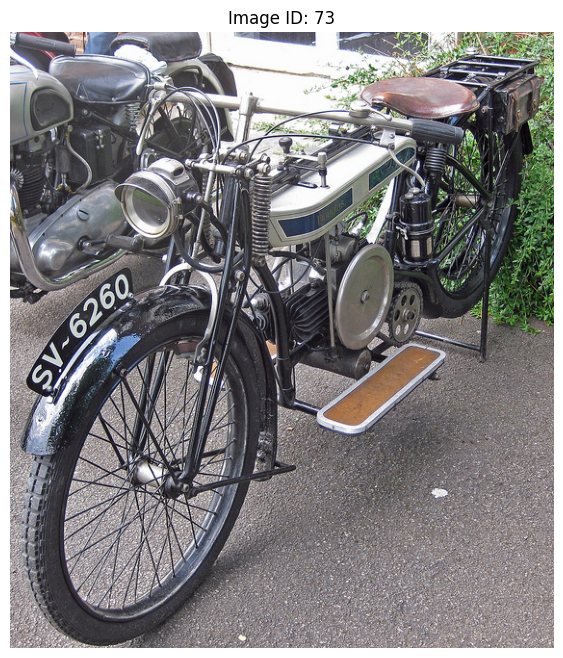

  Question: What is the license number?
    True Answer: sv-6260
    Model 1 (Frozen) Predicted: no
    Model 2 (Fine-tuned) Predicted: 0
------------------------------
  Question: Is this a motorcycle or bike?
    True Answer: motorcycle
    Model 1 (Frozen) Predicted: no
    Model 2 (Fine-tuned) Predicted: man
------------------------------
  Question: What color is the bike?
    True Answer: black
    Model 1 (Frozen) Predicted: white
    Model 2 (Fine-tuned) Predicted: white
------------------------------
  Question: What letter and 3 numbers are on the tag?
    True Answer: sv-6260
    Model 1 (Frozen) Predicted: nothing
    Model 2 (Fine-tuned) Predicted: 0
------------------------------

--- Processing Image ID: 136 ---


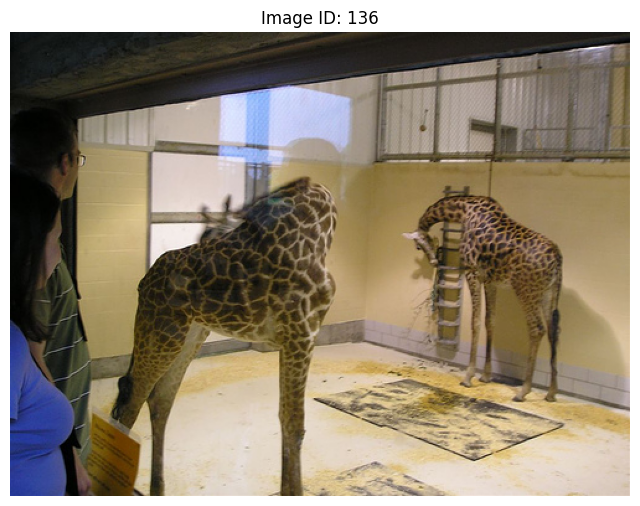

  Question: Is this in a museum?
    True Answer: no
    Model 1 (Frozen) Predicted: no
    Model 2 (Fine-tuned) Predicted: no
------------------------------
  Question: How many animals are in the picture?
    True Answer: 2
    Model 1 (Frozen) Predicted: 2
    Model 2 (Fine-tuned) Predicted: 1
------------------------------
  Question: What kind of animal is shown?
    True Answer: giraffe
    Model 1 (Frozen) Predicted: giraffe
    Model 2 (Fine-tuned) Predicted: giraffe
------------------------------


In [ ]:
# --- 8. Inference (Prediction on a Sample from Test Set) ---

print("\n--- Performing Inference on the first 2 unique images from the Test Set ---")

# Get unique image IDs from the test set
test_image_ids = np.array([d['original_image_id'] for d in test_data_filtered])
unique_test_image_ids = np.unique(test_image_ids)

# Select the first two unique image IDs
images_to_infer = unique_test_image_ids[:2] # Take the first two


# Directly proceed with the loop as images are guaranteed to be present from preprocessing
for current_image_id in images_to_infer:
    print(f"\n--- Processing Image ID: {current_image_id} ---")

    # Get all samples (questions) for this specific image ID
    samples_for_current_image = [d for d in test_data_filtered if d['original_image_id'] == current_image_id]

    # Display the image once
    try:
        image_filename = f"COCO_val2014_{str(current_image_id).zfill(12)}.jpg"
        image_path = os.path.join(IMAGE_DIR, image_filename)
        # The image should exist at this point, but a final check is robust
        if os.path.exists(image_path):
            img_display = Image.open(image_path).convert('RGB')
            plt.figure(figsize=(8, 8))
            plt.imshow(img_display)
            plt.title(f"Image ID: {current_image_id}", fontsize=12)
            plt.axis('off')
            plt.show()
        else:
            # This case should ideally not be hit if preprocessing was thorough
            print(f"Warning: Image file not found for display at {image_path}, even after preprocessing.")
    except Exception as e:
        print(f"Error displaying image {current_image_id}: {e}")

    # Now, iterate through all questions related to this image and perform inference
    for sample_info in samples_for_current_image:
        sample_image_features = torch.tensor(sample_info['image_features'], dtype=torch.float32).unsqueeze(0).to(device)
        sample_input_ids = torch.tensor(sample_info['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
        sample_attention_mask = torch.tensor(sample_info['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
        sample_token_type_ids = torch.tensor(sample_info['token_type_ids'], dtype=torch.long).unsqueeze(0).to(device)
        true_answer_label_id = sample_info['answer_id']

        original_question_text = sample_info['original_question']
        true_answer = answer_label_encoder.inverse_transform([true_answer_label_id])[0]

        # Predictions for Model 1
        visualbert_m1.eval()
        classifier_m1.eval()
        with torch.no_grad():
            visual_embeds_for_visualbert_m1 = sample_image_features.unsqueeze(1)
            visual_attention_mask_m1 = torch.ones_like(visual_embeds_for_visualbert_m1[:, :, 0], dtype=torch.long)
            visualbert_output_m1 = visualbert_m1(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                token_type_ids=sample_token_type_ids,
                visual_embeds=visual_embeds_for_visualbert_m1,
                visual_attention_mask=visual_attention_mask_m1
            )
            combined_representation_m1 = visualbert_output_m1.pooler_output
            predicted_logits_m1 = classifier_m1(combined_representation_m1)

        predicted_probabilities_m1 = torch.softmax(predicted_logits_m1, dim=-1).cpu().numpy()[0]
        predicted_answer_id_m1 = np.argmax(predicted_probabilities_m1)
        predicted_answer_m1 = answer_label_encoder.inverse_transform([predicted_answer_id_m1])[0]

        # Predictions for Model 2
        visualbert_m2.eval()
        classifier_m2.eval()
        with torch.no_grad():
            visual_embeds_for_visualbert_m2 = sample_image_features.unsqueeze(1)
            visual_attention_mask_m2 = torch.ones_like(visual_embeds_for_visualbert_m2[:, :, 0], dtype=torch.long)
            visualbert_output_m2 = visualbert_m2(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                token_type_ids=sample_token_type_ids,
                visual_embeds=visual_embeds_for_visualbert_m2,
                visual_attention_mask=visual_attention_mask_m2
            )
            combined_representation_m2 = visualbert_output_m2.pooler_output
            predicted_logits_m2 = classifier_m2(combined_representation_m2)

        predicted_probabilities_m2 = torch.softmax(predicted_logits_m2, dim=-1).cpu().numpy()[0]
        predicted_answer_id_m2 = np.argmax(predicted_probabilities_m2)
        predicted_answer_m2 = answer_label_encoder.inverse_transform([predicted_answer_id_m2])[0]

        print(f"  Question: {original_question_text}")
        print(f"    True Answer: {true_answer}")
        print(f"    Model 1 (Frozen) Predicted: {predicted_answer_m1}")
        print(f"    Model 2 (Fine-tuned) Predicted: {predicted_answer_m2}")
        print("-" * 30) # Separator for questions

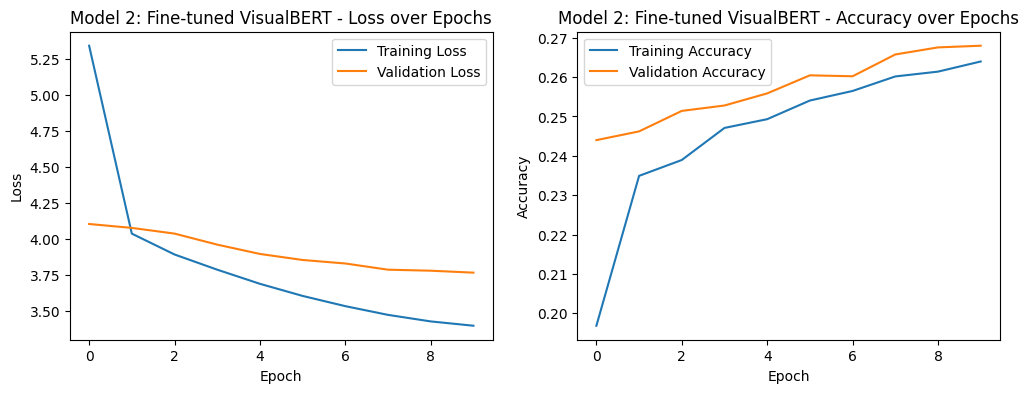


Model 2 Final Training Accuracy: 0.2640
Model 2 Final Validation Accuracy: 0.2680
Model 2 Final Test Accuracy: 0.2702


In [ ]:
# Model 2 History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_m2['loss'], label='Training Loss')
plt.plot(history_m2['val_loss'], label='Validation Loss')
plt.title('Model 2: Fine-tuned VisualBERT - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_m2['accuracy'], label='Training Accuracy')
plt.plot(history_m2['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2: Fine-tuned VisualBERT - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"\nModel 2 Final Training Accuracy: {history_m2['accuracy'][-1]:.4f}")
print(f"Model 2 Final Validation Accuracy: {history_m2['val_accuracy'][-1]:.4f}")
print(f"Model 2 Final Test Accuracy: {test_accuracy_m2:.4f}")

##### Need more number of epochs to be a good model

#### Comparing models

Evaluation for Model 1 (Frozen VisualBERT + Head):
Evaluating Model: 100%|█| 2673/2673 [00:49<00:00, 53.60it/s, acc=0.281, loss=7.0
  Test Loss: 3.9324
  Test Categorical Accuracy: 0.2810

--- Aggregated Classification Metrics (Model 1) ---
  Overall Accuracy: 0.2810
  Macro Avg Precision: 0.0012
  Macro Avg Recall: 0.0015
  Macro Avg F1-score: 0.0010


Evaluation for Model 2 (Fine-tuned VisualBERT + Head):
Evaluating Model: 100%|█| 2673/2673 [00:49<00:00, 53.89it/s, acc=0.27, loss=5.73
  Test Loss: 3.7551
  Test Categorical Accuracy: 0.2702

--- Aggregated Classification Metrics (Model 2) ---
  Overall Accuracy: 0.2702
  Macro Avg Precision: 0.0004
  Macro Avg Recall: 0.0010
  Macro Avg F1-score: 0.0005

#### Class imbalance and lower number of epochs are two problems for the poor performance of models.